In [4]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [6]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 4

trainset = torchvision.datasets.CIFAR10(root='C:/gagnanam_datasets/06_section1/', train=True,
                                        download=False, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='C:/gagnanam_datasets/06_section1/', train=False,
                                       download=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

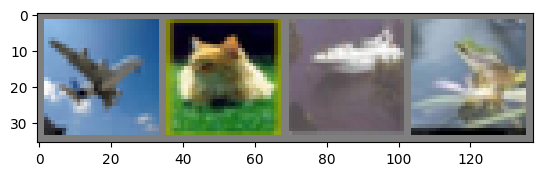

plane cat   ship  frog 


In [7]:
# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [8]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

In [9]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [10]:
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 2.119
[1,  4000] loss: 1.772
[1,  6000] loss: 1.611
[1,  8000] loss: 1.557
[1, 10000] loss: 1.488
[1, 12000] loss: 1.455
[2,  2000] loss: 1.385
[2,  4000] loss: 1.349
[2,  6000] loss: 1.346
[2,  8000] loss: 1.302
[2, 10000] loss: 1.279
[2, 12000] loss: 1.246
Finished Training


In [11]:
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

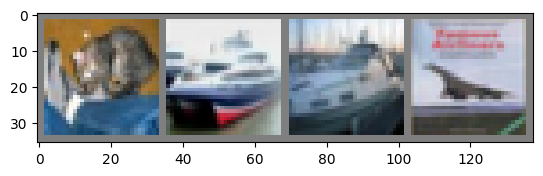

GroundTruth:  cat   ship  ship  plane


In [12]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

In [13]:
net = Net()
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [14]:
outputs = net(images)

In [15]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(4)))

Predicted:  cat   ship  ship  ship 


In [16]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 55 %


In [17]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: plane is 60.8 %
Accuracy for class: car   is 73.1 %
Accuracy for class: bird  is 43.4 %
Accuracy for class: cat   is 45.0 %
Accuracy for class: deer  is 39.7 %
Accuracy for class: dog   is 26.1 %
Accuracy for class: frog  is 66.4 %
Accuracy for class: horse is 69.3 %
Accuracy for class: ship  is 69.6 %
Accuracy for class: truck is 60.9 %


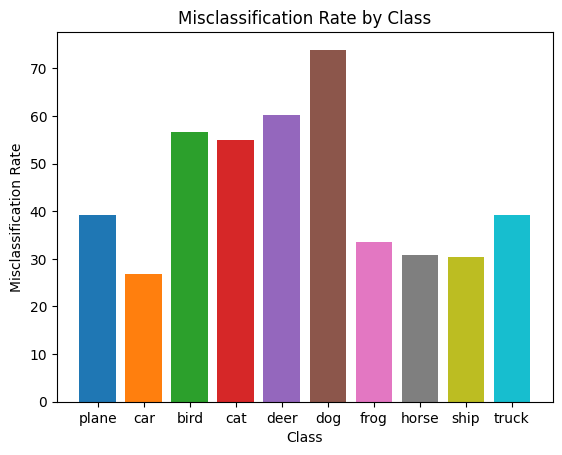

In [18]:
# plot misclassification rate for each class
def plot_misclassification_rate(classname, correct_count, total_count):
    for classname, correct_count in correct_pred.items():
        accuracy = 100 * float(correct_count) / total_pred[classname]
        misclassification_rate = 100 - accuracy
        plt.bar(classname, misclassification_rate)

    plt.xlabel('Class')
    plt.ylabel('Misclassification Rate')
    plt.title('Misclassification Rate by Class')
    plt.show()

plot_misclassification_rate(classes, correct_pred.values(), total_pred.values())


In [19]:
# calculate confusion matrix 
def confusion_matrix(classes, correct_count, total_count):
    confusion_matrix = torch.zeros(len(classes), len(classes))
    with torch.no_grad():
        for i, (inputs, classes) in enumerate(testloader):
            outputs = net(inputs)
            _, predictions = torch.max(outputs, 1)
            for t, p in zip(classes.view(-1), predictions.view(-1)):
                    confusion_matrix[t.long(), p.long()] += 1

    return confusion_matrix

print(confusion_matrix(classes, correct_pred.values(), total_pred.values()))

tensor([[608.,  39.,  39.,  35.,  27.,   3.,  18.,  31., 157.,  43.],
        [ 14., 731.,  10.,  12.,  10.,   1.,  17.,   6.,  41., 158.],
        [ 92.,  16., 434., 115.,  99.,  29.,  95.,  67.,  30.,  23.],
        [ 24.,  13., 110., 450.,  75.,  71., 116.,  83.,  15.,  43.],
        [ 32.,  15., 167.,  79., 397.,  15., 112., 146.,  25.,  12.],
        [ 25.,   5., 148., 319.,  52., 261.,  50., 110.,  11.,  19.],
        [  3.,  13.,  85.,  82.,  83.,   4., 664.,  30.,  11.,  25.],
        [ 23.,   8.,  59.,  68.,  52.,  28.,  17., 693.,  10.,  42.],
        [ 92.,  67.,   7.,  40.,  11.,   3.,  10.,  13., 696.,  61.],
        [ 34., 189.,  12.,  23.,  13.,   5.,  18.,  39.,  58., 609.]])
